## Overview 

The increasing frequency and intensity of cyclonic rainfall events pose significant threats to insurance markets in climate-vulnerable coastal regions. In Phase 2 of the World Bank Climate Risk Challenge, our team *DelphiQ* presents a working prototype that integrates **quantum-enhanced risk forecasting** and **portfolio optimization** to address such challenges in coastal New Zealand.

We focus on **risk prediction** and **risk diversification**, developing a hybrid framework that leverages:

- A **Quantum Reuploading Unit (QRU)** for time-series rainfall forecasting,
- A **QAOA-based Conditional Value-at-Risk optimizer** for regional insurance allocation,
- A **smart parametric payout logic** for inclusive, fast-response insurance.

This notebook outlines the **technical implementation of the prototype**, simulation results, data-driven insights, and real-world stakeholder impact. It is designed as a proof-of-concept combining quantum innovation with scalable climate resilience.

---

## 👥 Team DelphiQ

- **Jacinta May** – *Quantum Theorist & Lead* (BSc, Univ. of Sydney)  
  Co-founder of Pikkl. Expertise: Quantum hardware, environmental chemistry.

- **Sabarikirishwaran Ponnambalam** – *Quantum Algorithms* (PhD, Griffith University)  
  Specialist in QAOA, Variational Circuits, Quantum Optimization.

- **Léa Cassé** – *Quantum Machine Learning & Environmental Data* (PhD, Univ. of Waikato / École Polytechnique)  
  Expertise: QRU-based models, forecasting, TAIAO project collaborator.

- **Nicolas De Matteis** – *Business Lead* (BEng, UNSW)  
  Commercialization of quantum tech, environmental business ventures.

- **Greg Pearson** – *Data Scientist* (MetService)  
  Meteorological Design Engineer, MetService and TAIAO project member.


### 🌧️ Auckland Region – Eligible Rivers for Climate Risk Study

Rivers either within Auckland or under its greater hydrological influence (e.g., Franklin, Hauraki Plains, Coromandel). All are **≥ 50 km** in length and **≥ 2 m** in depth.

---

- **Marokopa River – Falls <span style="color: red;">[Selected for this Study]</span>** 
  • Depth: 2.25 m  
  • Region: Waikato / Auckland border  
  • Length: ~58 km  

- **Oraka Stream – Pinedale <span style="color: red;">[Selected for this Study]</span>** 
  • Depth: 2.01 m  
  • Region: Northern Waikato (Auckland catchment)  
  • Length: ~50+ km (assumed)

- **Waikato River (multiple sites) <span style="color: red;">[Selected for this Study]</span>**
  • Depths: 6.72 – 11.69 m  
  • Region: Hamilton → Auckland supply  
  • Length: 425 km  

- **Waipa River (Otewa, SH23, SH31)**  
  • Depths: 9.02 – 28.30 m  
  • Region: Waikato  
  • Length: 115 km  

- **Waihou River (Okauia, Te Aroha)**  
  • Depths: 2.38 – 7.35 m  
  • Region: Hauraki / Coromandel  
  • Length: ~150 km  

- **Ohinemuri River (Karangahake, Queens Head)**  
  • Depths: 2.80 – 5.84 m  
  • Region: Coromandel / Hauraki  
  • Length: ~70 km  

## Package installation

In [2]:
!pip install --no-cache-dir torch torchvision torchaudio -q
!pip install --no-cache-dir pytorch-lightning -q
!pip install --no-cache-dir custatevec-cu12 -q
!pip install --no-cache-dir lightning pennylane-lightning-gpu -q
!pip install --no-cache-dir pandas matplotlib -q
#!pip install "jax[cuda11_pip]==0.4.28" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 272.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 289.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 295.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 287.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 334.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 331.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 301.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 290.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 240.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Data Preprocessing

In [4]:
import os
import io
import re
import gzip
import pandas as pd
import pennylane.numpy as np
from glob import glob
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter


def load_weather_data(folder_path='.', datetime_format='%d-%b-%Y %H:%M'):
    """
    Load all .csv weather files (rainfall/wind) in folder_path.        
    """
    datasets = {}
    # Expected headers
    expected_keywords = ['date', 'time', 'rain', 'wind']
    
    for file in glob(os.path.join(folder_path, '*.csv')):
        name = file.strip().replace('.csv','')
        name = re.sub(r'\s+', '', name)
        try:            
            with open(file, 'rt') as f:
                lines = f.readlines()
                            
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().split(" "))                
                if any(keyword in tokens for keyword in expected_keywords):
                    header_idx = idx
                    break                        
            
            # Load csv
            df = pd.read_csv(
                io.StringIO(''.join(lines[header_idx:])),
                dtype=str,
                low_memory=False
            )
            
            # Parse datetime
            if 'date' in df.columns and 'time' in df.columns:
                df['datetime'] = pd.to_datetime(
                    df['date'] + ' ' + df['time'],
                    format=datetime_format,
                    errors='coerce'
                )
                df.drop(columns=['date', 'time'], inplace=True)                
            else:
                # fallback
                dt_col = next((col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()), None) 
                df['datetime'] = pd.to_datetime(df[dt_col], format=datetime_format, errors='coerce')                
                df.drop(columns=[dt_col], inplace=True)
                        
            rename_map = {}
            for c in df.columns:
                lc = c.lower()
                if 'rain' in lc: 
                    rename_map[c] = 'rainfall_mm'
                if 'wind' in lc and 'speed' in lc:
                    rename_map[c] = 'wind_speed_mps'
            df.rename(columns=rename_map, inplace=True)
            df['wind_speed_mps'] = df['wind_speed_mps'].replace({'VRB': None, 'NA': None, 'NaN': None})
                        
            df = df[['datetime', 'rainfall_mm', 'wind_speed_mps']].copy()            
            df = df.dropna(subset=['datetime', 'rainfall_mm', 'wind_speed_mps'])                                
            df['rainfall_mm'] = pd.to_numeric(df['rainfall_mm'], errors='coerce')
            df['wind_speed_mps'] = pd.to_numeric(df['wind_speed_mps'], errors='coerce')
            
            df = df.sort_values('datetime').reset_index(drop=True)
            start_date = pd.Timestamp('2019-10-21')
            df = df[df['datetime'] >= start_date]                
            print(f"Weather loaded: {name} ({len(df)} rows)")
        
        except Exception as e:
            print(f"Skipping {name}: {e}")
    
    return df

def load_river_level_data(folder_path='.', river_sites=None, datetime_format='%Y-%m-%d %H:%M:%S'):
    """
    Load river level csv for specified river_sites.        
    """
    if river_sites is None:
        river_sites = ['waikato', 'waipa', '']
    datasets = {}
    expected_cols = ['date', 'time', 'wlvalue', 'flvalue']
    for file in glob(os.path.join(folder_path, '*.csv')) + glob(os.path.join(folder_path, '*.csv')):
        name = os.path.basename(file)
        
        if not any(site.lower() in name.lower() for site in river_sites):
            continue
        try:            
            opener = gzip.open if file.endswith('.gz') else open
            with opener(file, 'rt') as f:
                lines = f.readlines()
            
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().replace(',',' ').split())                
                if any(keyword in tokens for keyword in expected_cols):
                    header_idx = idx
                    break
                                
            df = pd.read_csv(
                io.StringIO(''.join(lines[header_idx:])),
                dtype=str, low_memory=False
            )            
                    
            if 'date' in df.columns and 'time' in df.columns:                
                df['dt'] = df['date'] + ' ' + df['time']                                
                df['datetime'] = pd.to_datetime(
                    df['dt'],
                    format=datetime_format,
                    errors='coerce'
                )                
                df.drop(columns=['date', 'time', 'dt'], inplace=True)                
                        
            df['river_level'] = df['wlvalue'].astype(float)
            df = df.dropna(subset=['datetime', 'river_level'])            
            df = df[['datetime', 'river_level']].sort_values('datetime')
            df = df.set_index('datetime')
            #resample data hourly
            df = df.resample('h').ffill()  
            print(f"River loaded: {name} ({len(df)} rows)")
            datasets[name] = df
        except Exception as e:
            print(f"Skipping river {name}: {e}")
    return datasets

def merge_weather_and_river(weather_df, river_df):
    """
    Merge weather and river level data on exact datetime match (inner join).    
    """
    weather_df = weather_df.copy()
    river_df = river_df.copy()    
    
    # Inner join on exact datetime match
    merged = pd.merge(weather_df, river_df, on='datetime', how='inner')

    #print(f"Merged {len(merged)} rows on datetime match")

    return merged

def visualize_merged_data(data, threshold=150, title='Merged Timeseries'):
    """
    Plot rainfall and river level with threshold line.
    """
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(data['datetime'], data['rainfall_mm'], label='Rainfall (mm)', color='blue')
    ax1.set_xlabel('Datetime'); ax1.set_ylabel('Rainfall (mm)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')    
    
    ax2 = ax1.twinx()
    ax2.plot(data['datetime'], data['river_level'], label='River Level (m)', color='green')
    ax2.set_ylabel('River Level (m)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    #fig.tight_layout()
    plt.title(title)
    fig.legend()
    plt.show()

# Load data
weather_data = load_weather_data(folder_path='/kaggle/input/wbcfull/rainfall_data')
river_data = load_river_level_data(folder_path='/kaggle/input/wbcfull/riverlevel_data', river_sites=['waikato','waipa', 'waihou'])
merged_data = {}

# Merge matching datasets
for rname, rdata in river_data.items():
    merged_data[rname] = merge_weather_and_river(weather_data, rdata)

key = next(iter(merged_data))
df_merge = merged_data[key]

Weather loaded: /kaggle/input/wbcfull/rainfall_data/Observations_Hourly_Auckland_Aerodrome_NZAAA_1993Jan01_2025May23 (48875 rows)
River loaded: River Level - Waipa River - SH23 Br Whatawhata - 1st Jan 2019 - 23rd May 2025.csv (48960 rows)
River loaded: RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv (48960 rows)
River loaded: River Level - Waihou River - Te Aroha - ADCP - 1st Jan 2019 - 23rd May 2025.csv (48960 rows)
River loaded: River Level - Waikato River - Ngaruawahia Cableway - 1st Jan 2019 - 23rd May 2025.csv (48960 rows)
River loaded: River Level - Waihou River - Okauia - 1st Jan 2019 - 23rd May 2025.csv (45576 rows)
River loaded: River Level - Waikato River - Huntly Power Station - 1st Jan 2019 - 23rd May 2025.csv (48960 rows)
River loaded: RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv (48960 rows)
River loaded: River Level - Waipa River - SH23 Br Whatawhata - 1st Jan 2019 - 23rd May 2025.csv (48960 rows)
River loaded: RiverLevel-WaipaRiver-Otewa-

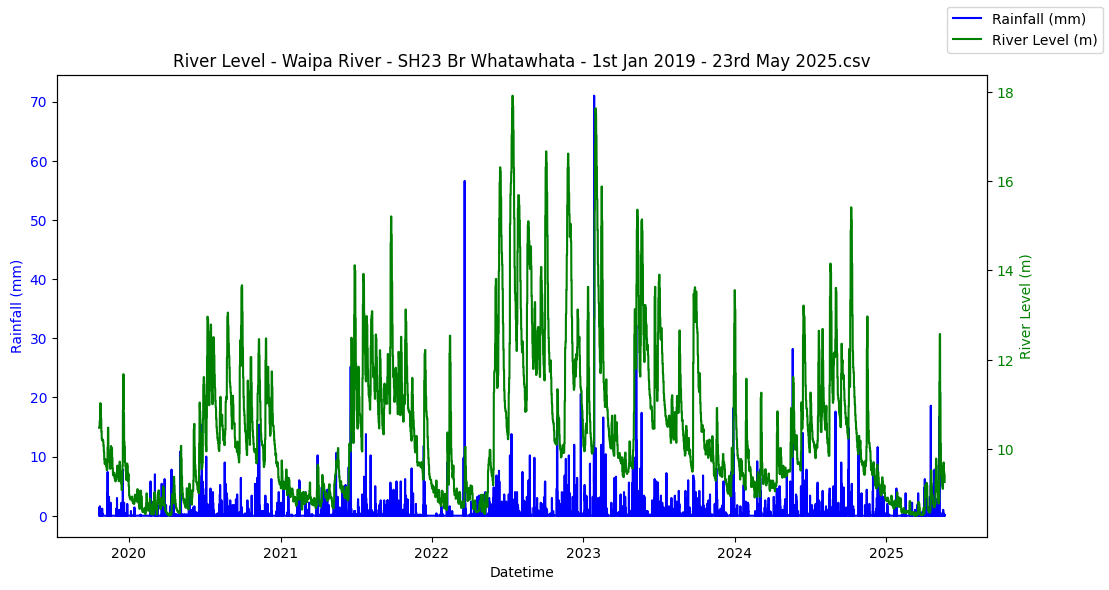

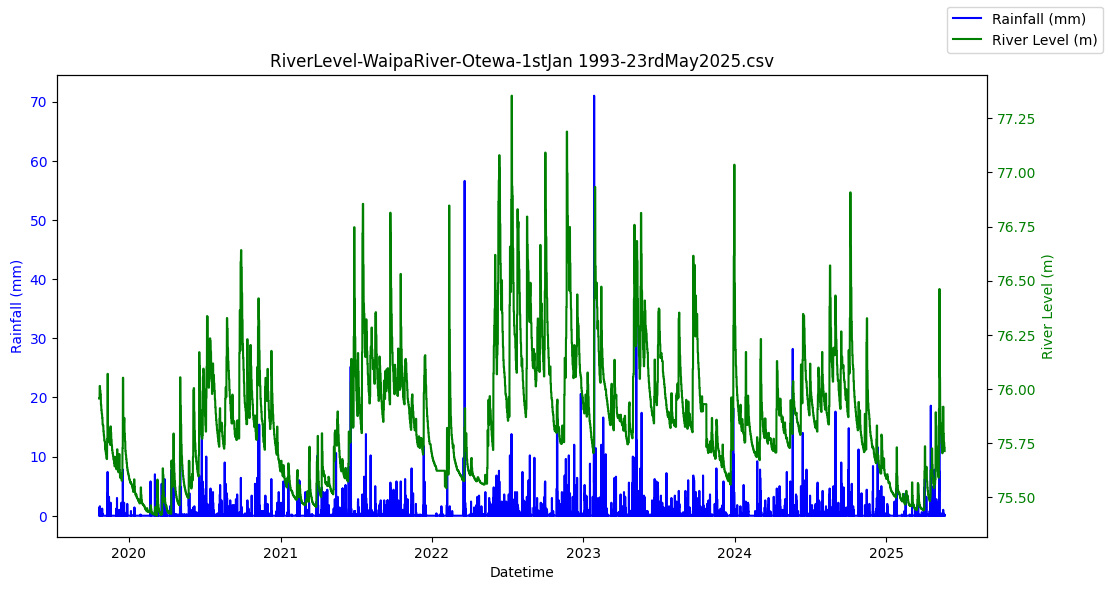

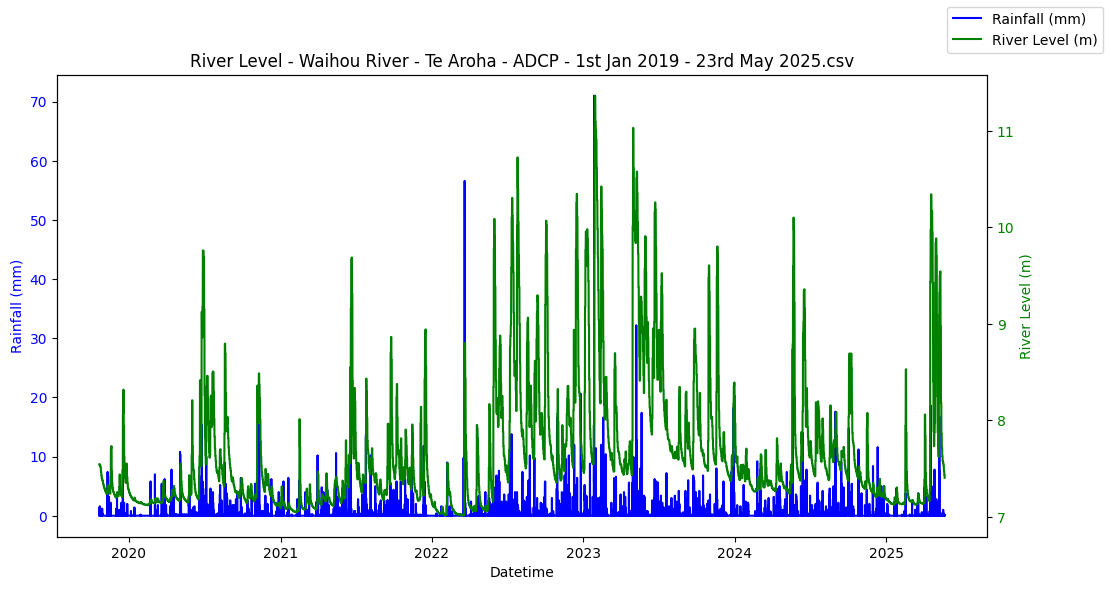

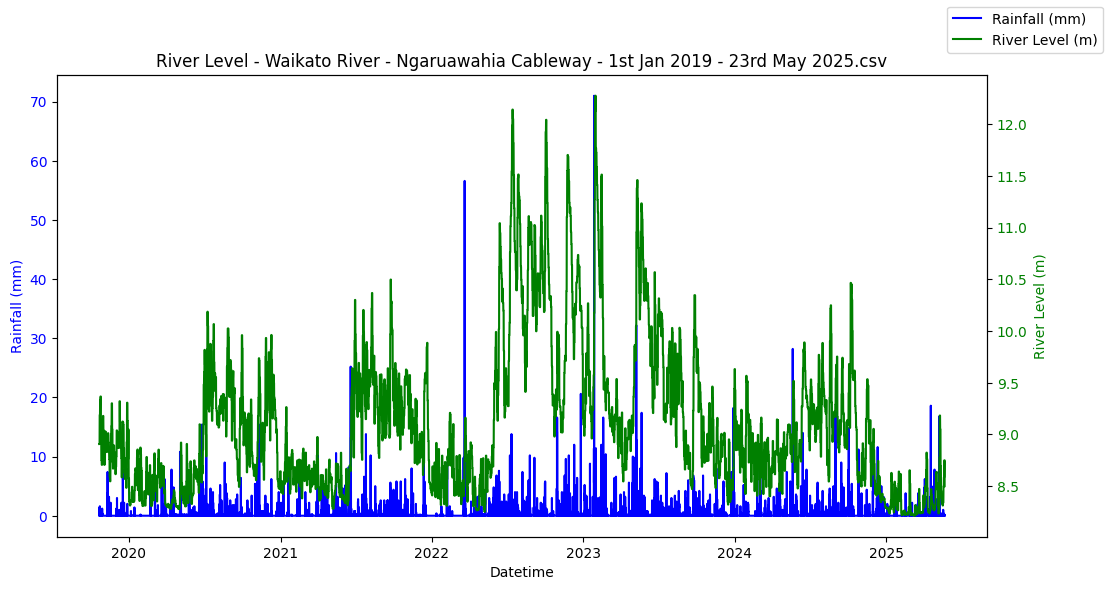

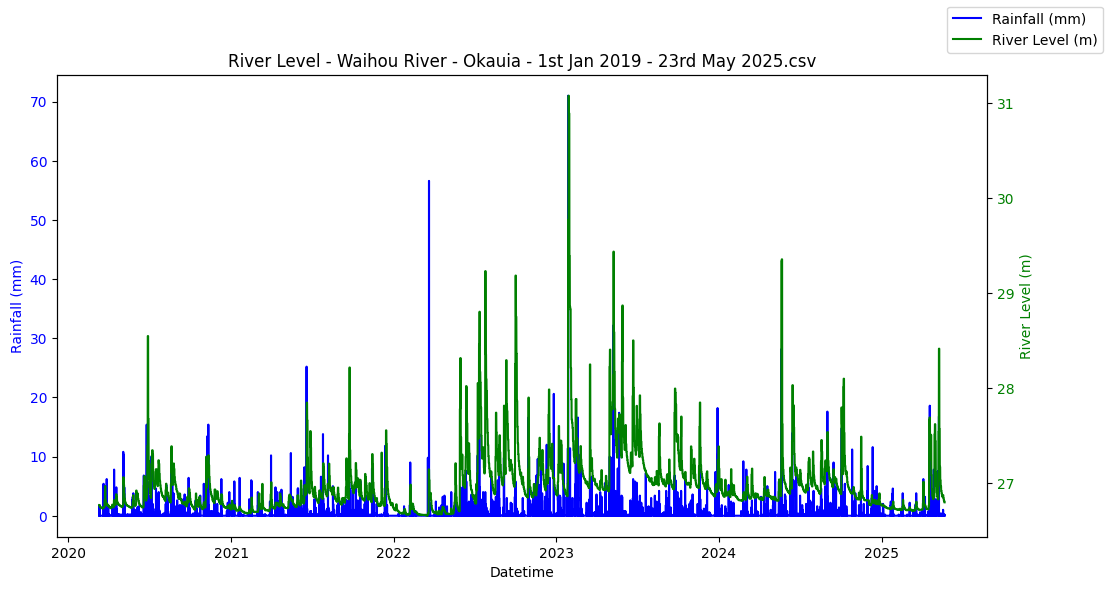

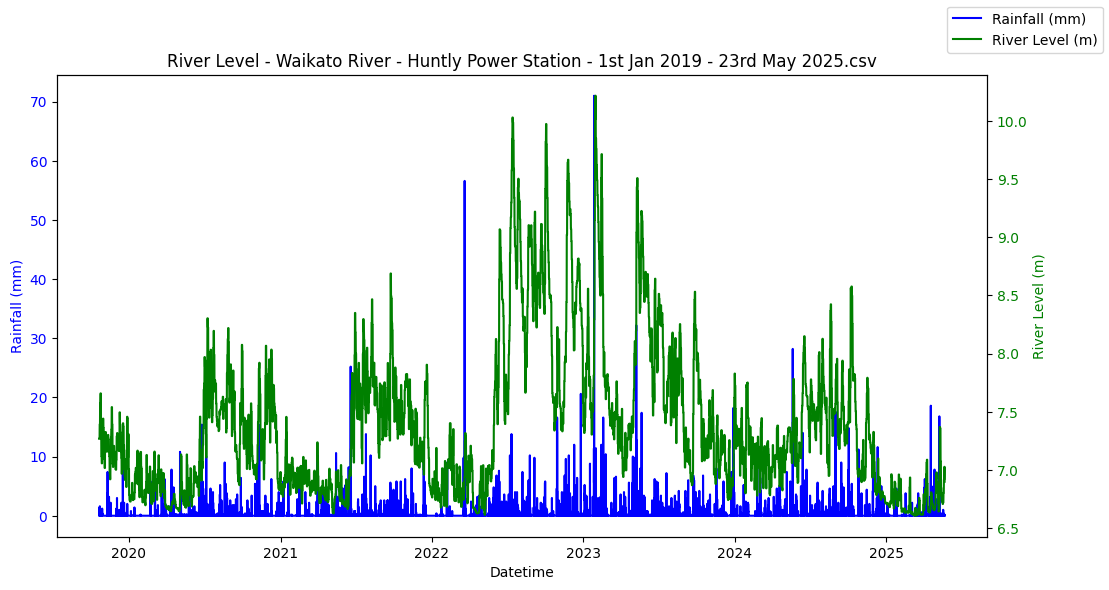

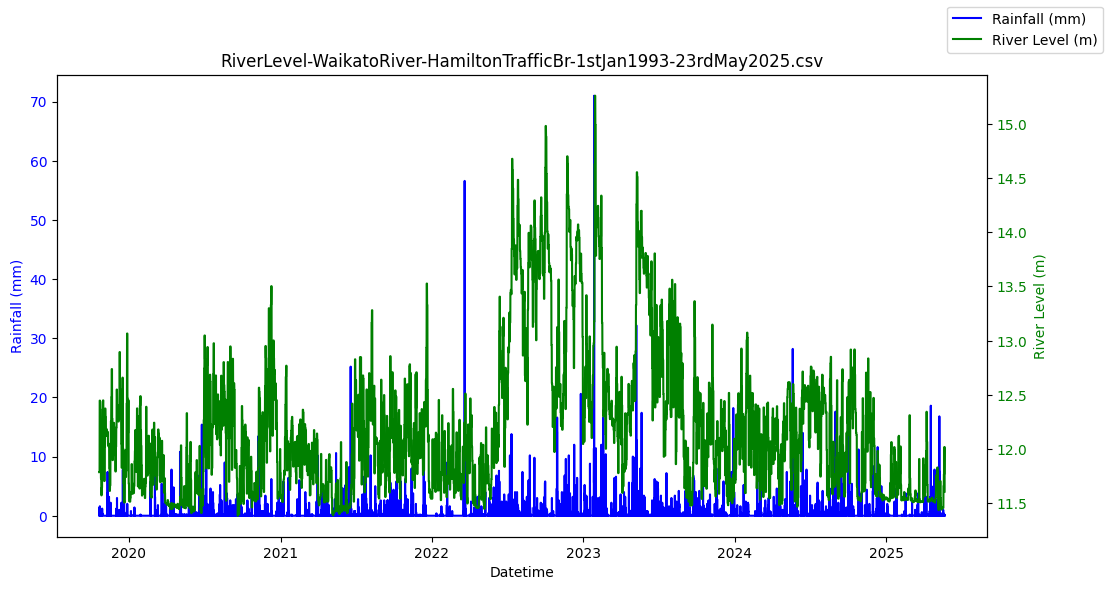

In [5]:
# Visualize
for key, df_merge in merged_data.items():    
    visualize_merged_data(df_merge, title=key)

In [6]:
print(merged_data.keys())
merged_data['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv']

dict_keys(['River Level - Waipa River - SH23 Br Whatawhata - 1st Jan 2019 - 23rd May 2025.csv', 'RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv', 'River Level - Waihou River - Te Aroha - ADCP - 1st Jan 2019 - 23rd May 2025.csv', 'River Level - Waikato River - Ngaruawahia Cableway - 1st Jan 2019 - 23rd May 2025.csv', 'River Level - Waihou River - Okauia - 1st Jan 2019 - 23rd May 2025.csv', 'River Level - Waikato River - Huntly Power Station - 1st Jan 2019 - 23rd May 2025.csv', 'RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv'])


,datetime,rainfall_mm,wind_speed_mps,river_level
0,2019-10-21 01:00:00,0.2,8.8,11.787
1,2019-10-21 02:00:00,0.0,8.8,11.787
2,2019-10-21 03:00:00,0.0,8.8,11.787
3,2019-10-21 04:00:00,0.0,8.8,11.787
4,2019-10-21 05:00:00,0.0,8.8,11.787
...,...,...,...,...
48845,2025-05-21 20:00:00,0.0,0.5,12.019
48846,2025-05-21 21:00:00,0.0,1.0,12.019
48847,2025-05-21 22:00:00,0.0,0.5,12.019
48848,2025-05-21 23:00:00,0.0,0.5,12.019


## QRU model for River Level Forecasting

Data shape: (32300, 4)


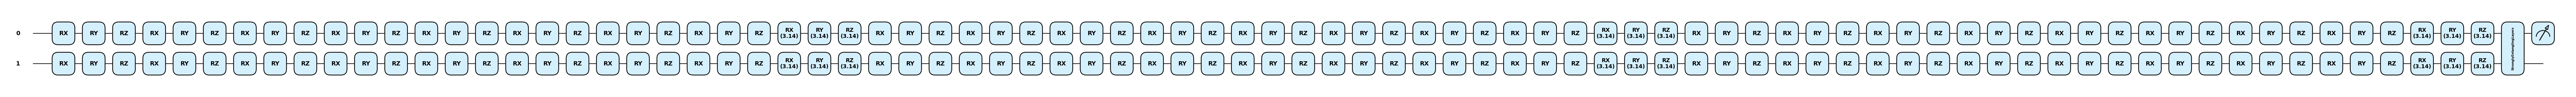

Trainable parameters: 168


Training QRU_Waikato:   0%|          | 0/50 [06:09<?, ?it/s]


KeyboardInterrupt: 

In [14]:
import random
import pandas as pd
import pennylane as qml
import numpy as np
import torch
import matplotlib.pyplot as plt
import csv
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

nb_reuploading = 3
lookback = 24  # window size
feature_col = ['rainfall_mm','wind_speed_mps']
X_features = len(feature_col)
target_col = ['river_level']
y_features = len(target_col)

nb_qubit_reupload = X_features
num_variational = 3
nb_epoch = 50
lr = 0.01
batch_size = 8

dev_reupload = qml.device("default.qubit", wires=nb_qubit_reupload, shots=None)

def generate_windowed_dataset(data, lookback=24, feature_cols=None, target_col='river_level'):
    """
    Create (X, y) with features from lookback hours    
    """
    if feature_cols is None:
        feature_cols = [c for c in ['rainfall_mm','wind_speed_mps'] if c in data.columns]
    X, y = [], []
    for i in range(len(data) - lookback):
        window = data[feature_cols].iloc[i:i+lookback].values
        target = data[target_col].iloc[i + lookback]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

def encoding_layer(params_encoding, x, lookback, nb_qubit):        
    x = x.reshape(-1, lookback, X_features)
    #print("params_encoding.shape, x.shape", params_encoding.shape, x.shape)
    
    rotation_gates = [qml.RX, qml.RY, qml.RZ]
    for q in range(X_features):
        for j in range(lookback):            
            gate = rotation_gates[j % len(rotation_gates)]            
            gate(params_encoding[q,j] * x[:,j,q], wires=q)

def variational_layer(params_variational, lookback, nb_qubit, num_variational):
    #print("params_variational.shape", params_variational.shape)
    rotation_gates = [qml.RX, qml.RY, qml.RZ]
    for q in range(nb_qubit):
        for k in range(num_variational):
            gate = rotation_gates[k % len(rotation_gates)]                        
            gate(params_variational[q, k], wires=q)

@qml.qnode(dev_reupload, interface="torch", diff_method="backprop")
def quantum_circuit_reupload(x, params):
    params_enc, params_var, ent_wieghts = params        
    for i in range(nb_reuploading):
        encoding_layer(params_enc[i], x, lookback, nb_qubit_reupload)
        variational_layer(params_var[i], lookback, nb_qubit_reupload, num_variational)

    qml.StronglyEntanglingLayers(weights=ent_wieghts, wires=range(nb_qubit_reupload))    
    #return  [qml.expval(qml.PauliZ(i)) for i in range(nb_qubit_reupload)]
    return qml.expval(qml.PauliZ(0))

def prediction_accuracy(y_pred, y_true, tolerance=0.1):
    correct = torch.sum(torch.abs(y_pred - y_true) < tolerance)
    return 100 * correct / len(y_true)

def split_data(data, test_ratio, lookback, target_col):
    X, y = generate_windowed_dataset(data, lookback=lookback, target_col=target_col)
    split = int(len(X) * (1 - test_ratio))
    return X[:split], y[:split], X[split:], y[split:]

def plot_metrics(loss_hist, acc_hist, grad_norm_hist, name):
    epochs = range(1, len(loss_hist)+1)
    plt.figure()
    plt.plot(epochs, loss_hist, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{name}: Test Loss over Epochs")
    plt.legend()
    plt.savefig(f"{name}_loss_plot.png", dpi=300)
    plt.close()

    plt.figure()
    plt.plot(epochs, acc_hist, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{name}: Test Accuracy over Epochs")
    plt.legend()
    plt.savefig(f"{name}_accuracy_plot.png", dpi=300)
    plt.close()

    plt.figure()
    plt.plot(epochs, grad_norm_hist, label="Gradient Norm")
    plt.xlabel("Epochs")
    plt.ylabel("L2 Norm")
    plt.title(f"{name}: Gradient Norm over Epochs")
    plt.legend()
    plt.savefig(f"{name}_gradnorm_plot.png", dpi=300)
    plt.close()

def plot_predictions(y_true, y_pred, name):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label="Ground Truth", linewidth=2)
    plt.plot(y_pred, label="Predictions", linestyle="--")
    plt.xlabel("Index")
    plt.ylabel("Normalized Value")
    plt.title(f"{name}: Predictions vs Ground Truth")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{name}_prediction_plot.png", dpi=300)
    plt.close()

def train_and_eval(model, params_init, X_tr, y_tr, X_te, y_te, name, epochs, lr):
    params = [p.clone().detach().requires_grad_(True) for p in params_init]
    opt = torch.optim.Adam(params, lr=lr)
    loss_hist, acc_hist, grad_norm_hist = [], [], []
    param_count = sum(p.numel() for p in params if p.requires_grad)
    print(f"Trainable parameters: {param_count}")    
    mse_loss = torch.nn.MSELoss()
    train_ds = TensorDataset(X_tr, y_tr)    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=0)
    

    with open(f"{name}_metrics.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "test_loss", "test_acc", "grad_norm"])

        progress_bar = trange(epochs, desc=f"Training {name}")
        best_loss = float("inf")
        best_epoch = -1

        for ep in progress_bar:        
            for X_batch, y_batch in train_loader:
                #print("X_batch, y_batch shapes", X_batch.shape, y_batch.shape)
                opt.zero_grad()                
                preds = model(X_batch, params)
                #print("preds.shape", preds.shape)
                #preds = torch.stack(preds) if isinstance(preds, list) else preds                
                loss = mse_loss(preds.squeeze(), y_batch.squeeze())
                loss.backward()
                            
                total_norm = 0.0
                for p in params:
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                grad_norm = total_norm ** 0.5
                
                opt.step()

            with torch.no_grad():                   
                preds_t = model(X_te, params)
                loss_t = mse_loss(preds_t.squeeze(), y_te.squeeze()).item()
                acc_t = prediction_accuracy(preds_t, y_te).item()

            loss_hist.append(loss_t)
            acc_hist.append(acc_t)
            grad_norm_hist.append(grad_norm)

            if loss_t < best_loss:
                best_loss = loss_t
                best_epoch = ep + 1

            progress_bar.set_postfix({
                "Loss": f"{loss_t:.4f}",
                "Acc": f"{acc_t:.2f}%",
                "GradNorm": f"{grad_norm:.4f}",
                "BestEpoch": best_epoch
            })

            writer.writerow([ep+1, loss_t, acc_t, grad_norm])
            f.flush()

    plot_metrics(loss_hist, acc_hist, grad_norm_hist, name)
    torch.save([p.detach() for p in params], f"{name}_trained_params.pt")

    with torch.no_grad():
        #preds_final = torch.stack([model(params, x) for x in X_te])
        preds_final = model(X_te, params)
        with open(f"{name}_predictions.csv", "w", newline="") as f_pred:
            writer = csv.writer(f_pred)
            writer.writerow(["Index", "Actual", "Predicted"])
            for i, (true_val, pred_val) in enumerate(zip(y_te, preds_final)):
                writer.writerow([i, true_val.item(), pred_val.item()])
        plot_predictions(y_te.cpu().numpy(), preds_final.cpu().numpy(), name)
    print("Training Completed successfully!")

def draw_quantum_circuit():
    dummy_x = torch.rand((batch_size, lookback, X_features), dtype=torch.float64)
    
    dummy_params = [
        torch.ones((nb_reuploading, nb_qubit_reupload, lookback), dtype=torch.float64) * np.pi,
        torch.ones((nb_reuploading, nb_qubit_reupload, num_variational), dtype=torch.float64) * np.pi,
        torch.ones(qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=nb_qubit_reupload), dtype=torch.float64) * np.pi
    ]

    # Draw circuit    
    fig, ax = qml.draw_mpl(quantum_circuit_reupload, decimals=2, style="pennylane")(dummy_x, dummy_params)
    fig.savefig("/kaggle/working/QRU_circuit.png", dpi=600)
    plt.show()

data = merged_data['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv'].iloc[-32300:].copy() # Due to limited compute - trainning on last one year of data 
#data = merged_data['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv']
print(f"Data shape: {data.shape}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
draw_quantum_circuit()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_tr_np, y_tr_np, X_te_np, y_te_np = split_data(data=data, test_ratio=0.2, lookback=lookback, target_col=target_col)

# Fit scaler on training set only
X_tr_np_2d = X_tr_np.reshape(-1, X_features)
scaler_X.fit(X_tr_np_2d)
X_tr_np_scaled = scaler_X.transform(X_tr_np_2d).reshape(X_tr_np.shape)
X_te_np_scaled = scaler_X.transform(X_te_np.reshape(-1, X_features)).reshape(X_te_np.shape)

scaler_y.fit(y_tr_np.reshape(-1, 1))
y_tr_np_scaled = scaler_y.transform(y_tr_np.reshape(-1, 1)).reshape(-1)
y_te_np_scaled = scaler_y.transform(y_te_np.reshape(-1, 1)).reshape(-1)


X_tr = torch.tensor(X_tr_np_scaled, dtype=torch.float64).to(device)
y_tr = torch.tensor(y_tr_np_scaled, dtype=torch.float64).to(device)
X_te = torch.tensor(X_te_np_scaled, dtype=torch.float64).to(device)
y_te = torch.tensor(y_te_np_scaled, dtype=torch.float64).to(device)

ent_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=nb_qubit_reupload)

params_init_reupload = [
    torch.full((nb_reuploading, nb_qubit_reupload, lookback), np.pi, dtype=torch.float64, requires_grad=True).to(device),
    torch.full((nb_reuploading, nb_qubit_reupload, num_variational), np.pi, dtype=torch.float64, requires_grad=True).to(device),
    torch.full((ent_shape), np.pi, dtype=torch.float64, requires_grad=True).to(device)
]

train_and_eval(quantum_circuit_reupload, params_init_reupload, X_tr, y_tr, X_te, y_te, "QRU_Waikato", nb_epoch, lr)

## Calculate Risk Score from the forecasted data

In [10]:
import os
import pandas as pd
import numpy as np
import io
from glob import glob

def load_hist_stats_data(folder_path, datetime_format='%Y-%m-%d'):
    """
    Load cleaned historical statistics CSVs with detected headers and correct datetime parsing.
    """
    datasets = {}
    expected_cols = ["date", "median", "95per"]

    for file in glob(os.path.join(folder_path, '*.csv')):
        name = os.path.basename(file).replace('.csv', '')
        try:
            with open(file, 'r') as f:
                lines = f.readlines()

            # Find the first line that includes expected column names
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().replace(',', ' ').split())
                if any(col in tokens for col in expected_cols):
                    header_idx = idx
                    break

            df = pd.read_csv(io.StringIO(''.join(lines[header_idx:])), dtype=str)
            df.columns = ["dateTime", "date", "median", "min", "max", "5per", "95per", "mean"]
            df["date"] = pd.to_datetime(df["date"], format=datetime_format, errors="coerce").dt.date
            df = df.dropna()
            df = df.set_index("date").sort_index()
            df[["median", "95per"]] = df[["median", "95per"]].astype(float)            
            df = df[["median", "95per"]]

            datasets[name] = df
            print(f"Loaded: {name} ({len(df)} rows)")
        except Exception as e:
            print(f"Failed: {name} — {e}")
    return datasets

# Update path to hist_data
hist_folder_path = "/kaggle/input/wbcfull/hist_data"

# Load the data
hist_data_dict = load_hist_stats_data(hist_folder_path)

# Define the flood risk scoring function
def make_risk_function(df_hist):
    def compute_flood_risk(pred_date, predicted_level):
        ts = pd.to_datetime(pred_date).date()
        if ts not in df_hist.index:
            raise ValueError(f"Date {ts} not found in historical stats for this site.")

        med_val = df_hist.loc[ts, "median"]
        p95_val = df_hist.loc[ts, "95per"]

        if predicted_level <= med_val:
            return 0.0 if med_val == 0 else 0.5 * (predicted_level / med_val)
        if predicted_level >= p95_val:
            return 0.85
        return 0.5 + ((predicted_level - med_val) / (p95_val - med_val)) * 0.35
    return compute_flood_risk

# Build dictionary of risk functions
risk_functions = {
    site: make_risk_function(df_hist)
    for site, df_hist in hist_data_dict.items()
}

Loaded: River Levels - Waipa River - SH23 Br Whatawhata (150 rows)
Loaded: River Levels - Waipa River - Otewa (150 rows)
Loaded: River Levels - Waihou River - Te Aroha - ADCP (150 rows)
Loaded: River Levels - Waihou River - Okauia (149 rows)
Loaded: River Levels - Waikato River - Huntly Power Station (150 rows)
Loaded: River Levels - Waikato River - Hamilton Traffic Br (150 rows)
Loaded: River Levels - Waikato River - Ngaruawahia Cableway (150 rows)


## Constructing Correlation Matrix

### GeoLocal Information

### 📍 Site Classification: Climate Vulnerability and Insurance Underservice

| Site                  | River   | Type        | Climate Vulnerable? | Insurance Underserved? | Notes                                                                                                 |
| --------------------- | ------- | ----------- | ------------------- | ---------------------- | ----------------------------------------------------------------------------------------------------- |
| **HamiltonTrafficBr** | Waikato | Urban       | No                  | No                     | Major city with developed infrastructure, minimal agricultural activity, and strong insurer presence. |
| **Huntly**            | Waikato | Rural       | Yes                 | Yes                    | Flood-prone; agriculturally dependent; lower income; limited insurer interest.                        |
| **Rangiriri**         | Waikato | Rural       | Yes                 | Yes                    | Low-lying floodplain; high agricultural exposure; limited emergency services.                         |
| **SH23 (Whatawhata)** | Waipa   | Semi-Urban  | Moderate            | Yes                    | Fringe area; some agricultural presence; moderate risk; often falls into insurance gray zones.        |
| **Otewa**             | Waipa   | Rural       | Yes                 | Yes                    | Remote rural area with strong agricultural dependence and high flood risk.                            |
| **Te Aroha**          | Waihou  | Small Urban | Moderate-High       | Yes                    | Flood-prone small town with some agricultural dependence; moderate adaptive capacity.                 |
| **Okauia**            | Waihou  | Rural       | Yes                 | Yes                    | Rural, agriculture-based community; frequent flooding; minimal insurance coverage options.            |

---

### 🧭 Site Selection Criteria and Justification

* The selected sites along the **Waikato, Waipa, and Waihou rivers** in the greater Auckland region were chosen to evaluate geolocations that are both:

  * **Climate-vulnerable**, and
  * **Underserved by insurance services**

#### Selection was based on four criteria:

1. **Climate Risk Exposure**

   * Proximity to flood-prone rivers
   * Historical flood frequency as reported by **NIWA** and the **Waikato Regional Council**

2. **Socioeconomic Profile**

   * Population size, affluence, urban–rural classification
   * **Agricultural dependence** as a primary livelihood

3. **Market Attractiveness for Insurers**

   * Low population density and high climate risk result in:

     * Low insurance premiums
     * High liability
   * These factors make such locations less viable for traditional insurance offerings

4. **Infrastructure Quality and Emergency Response Capacity**

   * Presence (or absence) of flood mitigation systems
   * Local disaster preparedness and recovery resources

#### Supporting Evidence:

* According to New Zealand’s NIWA Flood Risk Assessment and Waikato Regional Council reports, seettlements at **Otewa**, **Okauia**, **Ngaruawahia**, and **Huntly** are located in low-lying floodplains with **recurrence intervals of 5–10 years** for riverine flooding.

* These rural communities rely heavily on **agriculture**, making them doubly exposed:

  * Physically, due to flooding
  * Economically, due to disruption of agricultural livelihoods

* These sites are often **overlooked by traditional insurance markets** due to low returns and high risks.

* Urban and semi-urban locations such as **HamiltonTrafficBr**, **Te Aroha**, and **SH23 (Whatawhata)** were included to provide a comparative perspective:

  * These locations have relatively higher infrastructure capacity
  * However, **some still experience varying levels of insurance underservice**, especially when infrastructure is outdated or exposure remains high

---

### ⚙️ Prototype Deployment

* A **limited number of sites** were selected for the **prototype demonstration** due to computational constraints.
* The proposed solution is **scalable** and will be expanded to a **larger set of sites in Phase 3** of the challenge.


In [11]:
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
from time import sleep

shapefile_path = "/kaggle/input/wbcfull/map_data/lds-nz-river-centrelines-topo-1500k-SHP/nz-river-centrelines-topo-1500k.shp"
rivers_gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)

site_metadata = {
    "HamiltonTrafficBr": {
        "location": "victoria bridge, New Zealand",
        "river": "Waikato",
        "type": "Urban",
        "climate_vulnerable": "No",
        "insurance_underserved": "No"
    },
    "Huntly": {
        "location": "Huntly, New Zealand",
        "river": "Waikato",
        "type": "Rural",
        "climate_vulnerable": "Yes",
        "insurance_underserved": "Yes"
    },
    "Ngaruawahia": {
        "location": "Ngaruawahia, New Zealand",
        "river": "Waikato",
        "type": "Rural",
        "climate_vulnerable": "Yes",
        "insurance_underserved": "Yes"
    },
    "SH23": {
        "location": "SH23, Whatawhata, New Zealand",
        "river": "Waipa",
        "type": "Semi-Urban",
        "climate_vulnerable": "Moderate",
        "insurance_underserved": "Yes"
    },
    "Otewa": {
        "location": "Otewa, New Zealand",
        "river": "Waipa",
        "type": "Rural",
        "climate_vulnerable": "Yes",
        "insurance_underserved": "Yes"
    },
    "Te Aroha": {
        "location": "Te Aroha, New Zealand",
        "river": "Waihou",
        "type": "Small Urban",
        "climate_vulnerable": "Moderate-High",
        "insurance_underserved": "Yes"
    },
    "Okauia": {
        "location": "Okauia, New Zealand",
        "river": "Waihou",
        "type": "Rural",
        "climate_vulnerable": "Yes",
        "insurance_underserved": "Yes"
    },
}

geolocator = Nominatim(user_agent="nz-river-mapper")
site_points = []

for site, info in site_metadata.items():
    try:
        location = geolocator.geocode(info["location"], timeout=10)
        if location:
            site_points.append({
                "name": site,
                "river": info["river"],
                "type": info["type"],
                "climate_vulnerable": info["climate_vulnerable"],
                "insurance_underserved": info["insurance_underserved"],
                "lat": location.latitude,
                "lon": location.longitude
            })
        else:
            print(f"Failed to locate: {info['location']}")
        sleep(1)
    except Exception as e:
        print(f"Error for {site}: {e}")

sites_gdf = gpd.GeoDataFrame(
    site_points,
    geometry=gpd.points_from_xy(
        [s["lon"] for s in site_points], [s["lat"] for s in site_points]),
    crs="EPSG:4326"
)

m = folium.Map(location=[-37.5, 175.5], zoom_start=8, tiles="CartoDB positron")

for _, row in rivers_gdf.iterrows():
    if row.geometry and row.geometry.is_valid:
        geo_json = gpd.GeoSeries([row.geometry]).simplify(0.001).to_json()
        folium.GeoJson(
            data=geo_json,
            style_function=lambda x: {
                'color': 'blue',
                'weight': 1.5,
                'opacity': 0.5
            }
        ).add_to(m)

for _, row in sites_gdf.iterrows():
    if row["climate_vulnerable"] == "Yes" and row["insurance_underserved"] == "Yes":
        color = "red"
    elif "Moderate" in row["climate_vulnerable"] or row["insurance_underserved"] == "Yes":
        color = "orange"
    else:
        color = "green"

    # Circle marker
    folium.CircleMarker(
        location=(row["lat"], row["lon"]),
        radius=40,
        popup=folium.Popup(
            f"<b>{row['name']}</b><br><b>Type:</b> {row['type']}<br><b>Risk:</b> {row['climate_vulnerable']}<br><b>Underserved:</b> {row['insurance_underserved']}",
            max_width=300),
        color=color,
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

    # Label with site name
    folium.map.Marker(
        [row["lat"], row["lon"]],
        icon=folium.DivIcon(
            icon_size=(150, 36),
            icon_anchor=(0, 0),
            html=f'<div style="font-size: 12px; color: black;">{row["name"]}</div>',
        )
    ).add_to(m)

legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 220px; height: 120px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px;">
  <b>Legend – Site Risk & Insurance Status</b><br>
  <i style="background:red; width:12px; height:12px; display:inline-block;"></i> High Risk & Underserved<br>
  <i style="background:orange; width:12px; height:12px; display:inline-block;"></i> Moderate/Partial Risk<br>
  <i style="background:green; width:12px; height:12px; display:inline-block;"></i> Low Risk & Covered
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m.save("nz_river_sites_map.html")
print("Map saved as `nz_river_sites_map.html`")

Map saved as `nz_river_sites_map.html`


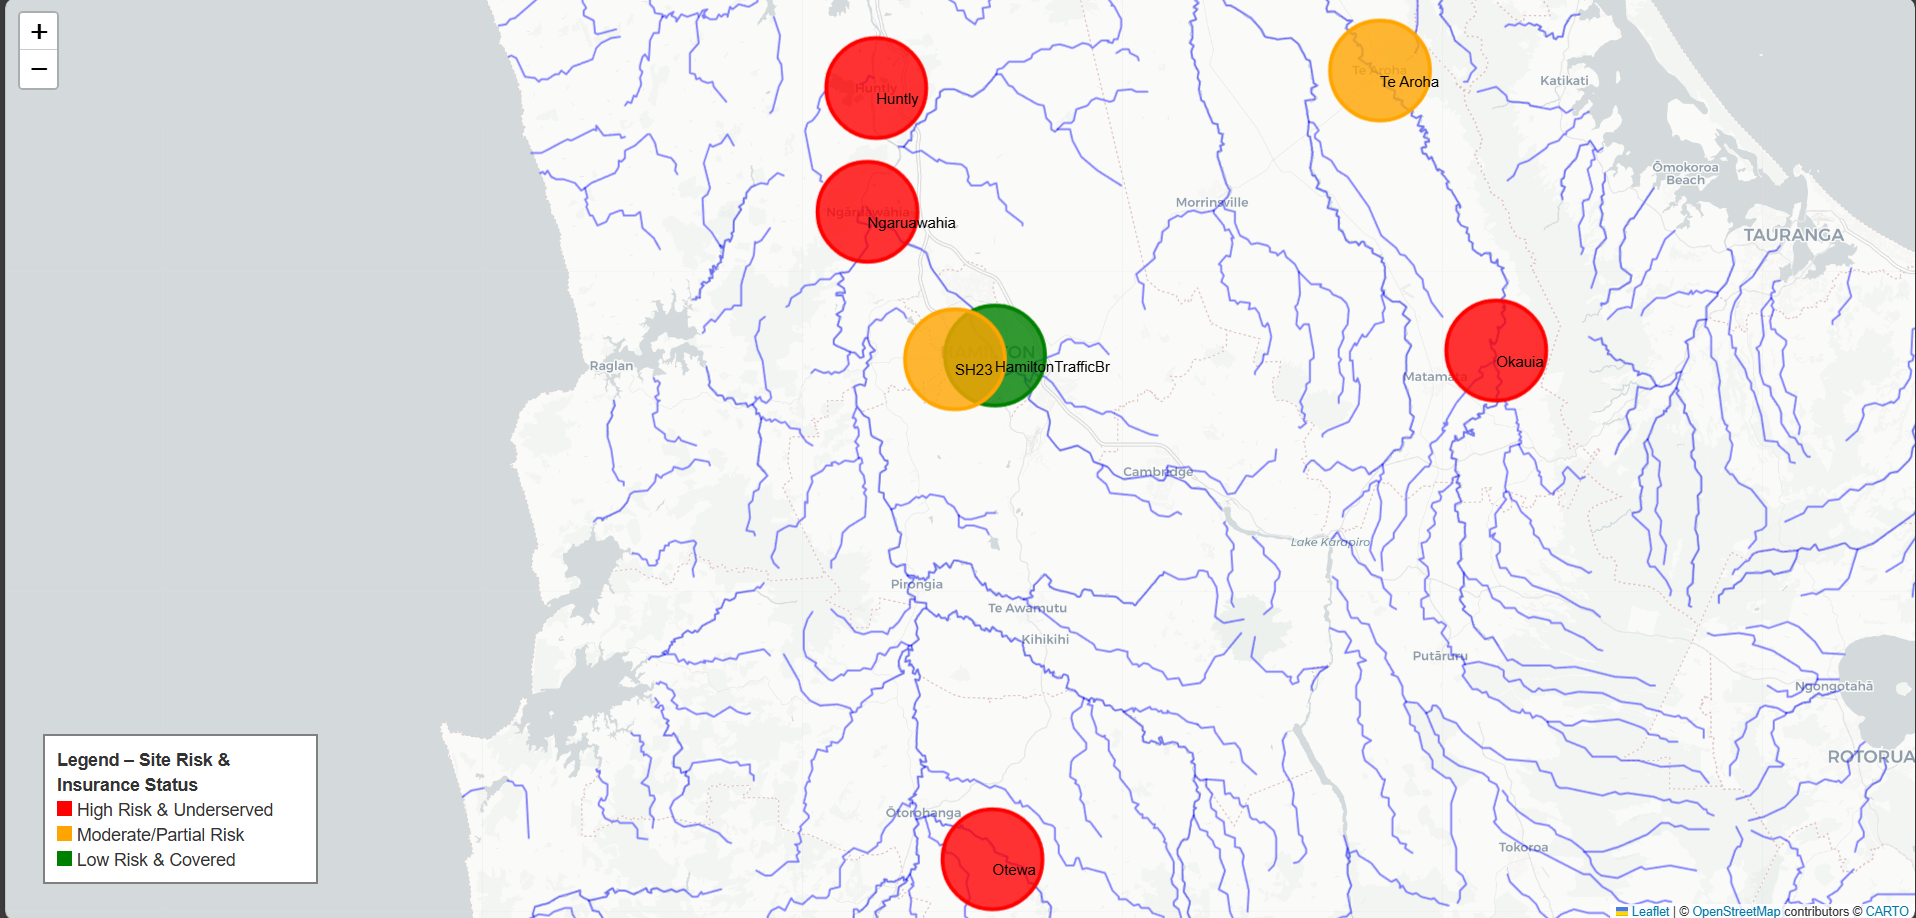

### Correlation Matrix

In [12]:
!pip install geopy --q

[✓] SH23, Whatawhata, New Zealand → (-37.7949, 175.2463)
[✓] Otewa, New Zealand → (-38.2274, 175.2875)
[✓] Te Aroha, New Zealand → (-37.5431, 175.7124)
[✓] Ngaruawahia, New Zealand → (-37.6663, 175.1501)
[✓] Okauia, New Zealand → (-37.7873, 175.8402)
[✓] Huntly Power Station, New Zealand → (-37.5441, 175.1488)
[✓] Victoria Bridge, New Zealand → (-37.7913, 175.2897)


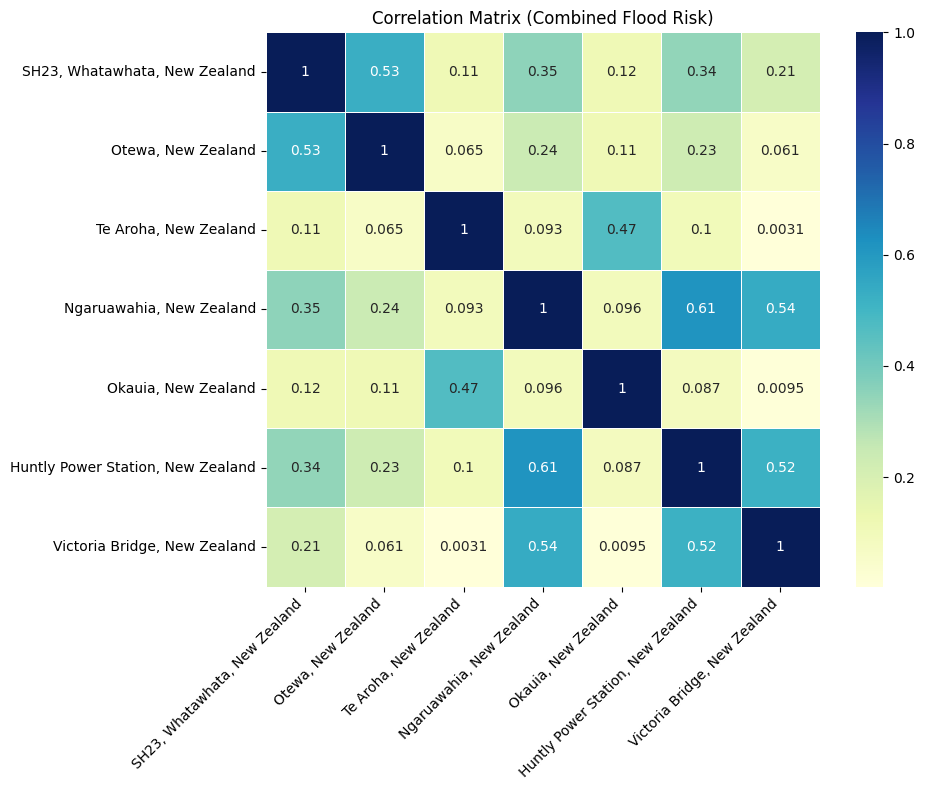

In [13]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from itertools import combinations

merged_data_keys = [
    'River Level - Waipa River - SH23 Br Whatawhata - 1st Jan 2019 - 23rd May 2025.csv',
    'RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv',
    'River Level - Waihou River - Te Aroha - ADCP - 1st Jan 2019 - 23rd May 2025.csv',
    'River Level - Waikato River - Ngaruawahia Cableway - 1st Jan 2019 - 23rd May 2025.csv',
    'River Level - Waihou River - Okauia - 1st Jan 2019 - 23rd May 2025.csv',
    'River Level - Waikato River - Huntly Power Station - 1st Jan 2019 - 23rd May 2025.csv',
    'RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv'
]

site_labels = {
    merged_data_keys[0]: "SH23, Whatawhata, New Zealand",        # Semi-urban (Waipa River)
    merged_data_keys[1]: "Otewa, New Zealand",                     # Rural (Waipa River)
    merged_data_keys[2]: "Te Aroha, New Zealand",           # Small urban (Waihou River)
    merged_data_keys[3]: "Ngaruawahia, New Zealand",               # Urban (Waikato River)
    merged_data_keys[4]: "Okauia, New Zealand",                    # Rural (Waihou River)
    merged_data_keys[5]: "Huntly Power Station, New Zealand",      # Rural (Waikato River)
    merged_data_keys[6]: "Victoria Bridge, New Zealand"           # Urban (Waikato River)
}

geolocator = Nominatim(user_agent="geoapi-qcorrelation")
site_locations = {}
for key, location in site_labels.items():
    try:
        loc = geolocator.geocode(location)
        if loc:
            site_locations[key] = (loc.latitude, loc.longitude)
            print(f"[✓] {location} → ({loc.latitude:.4f}, {loc.longitude:.4f})")
        else:
            print(f"[X] Could not find location: {location}")
        time.sleep(1)
    except Exception as e:
        print(f"[!] Error with {location}: {e}")

site_rivers = {
    merged_data_keys[0]: 'Waipa',
    merged_data_keys[1]: 'Waipa',
    merged_data_keys[2]: 'Waihou',
    merged_data_keys[3]: 'Waikato',
    merged_data_keys[4]: 'Waihou',
    merged_data_keys[5]: 'Waikato',
    merged_data_keys[6]: 'Waikato'
}

sites = list(site_locations.keys())
N = len(sites)
coflood_corr = np.zeros((N, N))
geo_proximity = np.zeros((N, N))
rainfall_dependency = np.zeros((N, N))
hydro_coupling = np.zeros((N, N))

for i, j in combinations(range(N), 2):
    si, sj = sites[i], sites[j]

    # --- Historical Co-Flooding ---
    df_i = merged_data[si][['datetime', 'river_level']].copy()
    df_j = merged_data[sj][['datetime', 'river_level']].copy()
    df_merged = pd.merge(df_i, df_j, on='datetime', suffixes=(f'_{i}', f'_{j}'))
    if not df_merged.empty:
        corr_val = df_merged[f'river_level_{i}'].corr(df_merged[f'river_level_{j}'])
        coflood_corr[i, j] = coflood_corr[j, i] = max(0, corr_val if pd.notna(corr_val) else 0)

    dist_km = geodesic(site_locations[si], site_locations[sj]).km
    geo_score = 1 / (1 + dist_km)
    geo_proximity[i, j] = geo_proximity[j, i] = geo_score
    
    if 'rainfall_mm' in merged_data[si].columns and 'river_level' in merged_data[sj].columns:
        df_i_rain = merged_data[si][['datetime', 'rainfall_mm']].copy()
        df_j_river = merged_data[sj][['datetime', 'river_level']].copy()
        df_lag = pd.merge(df_i_rain, df_j_river, on='datetime')
        corr_lag = df_lag['rainfall_mm'].corr(df_lag['river_level'])
        rainfall_dependency[i, j] = rainfall_dependency[j, i] = max(0, corr_lag if pd.notna(corr_lag) else 0)

    hydro_coupling[i, j] = hydro_coupling[j, i] = 1.0 if site_rivers[si] == site_rivers[sj] else 0.0

for mat in [coflood_corr, geo_proximity, rainfall_dependency, hydro_coupling]:
    np.fill_diagonal(mat, 1.0)

def normalize(mat):
    minv, maxv = np.min(mat), np.max(mat)
    return (mat - minv) / (maxv - minv) if maxv > minv else mat

coflood_corr = normalize(coflood_corr)
geo_proximity = normalize(geo_proximity)
rainfall_dependency = normalize(rainfall_dependency)
hydro_coupling = normalize(hydro_coupling)

alpha, beta, gamma, delta = 0.4, 0.3, 0.1, 0.2
composite_corr = (
    alpha * coflood_corr +
    beta * geo_proximity +
    gamma * rainfall_dependency +
    delta * hydro_coupling
)

df_corr = pd.DataFrame(composite_corr, index=[site_labels[s] for s in sites],
                       columns=[site_labels[s] for s in sites])

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='YlGnBu', square=True, linewidths=0.5)
plt.title("Correlation Matrix (Combined Flood Risk)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# QAOA

## Circuit Illustration

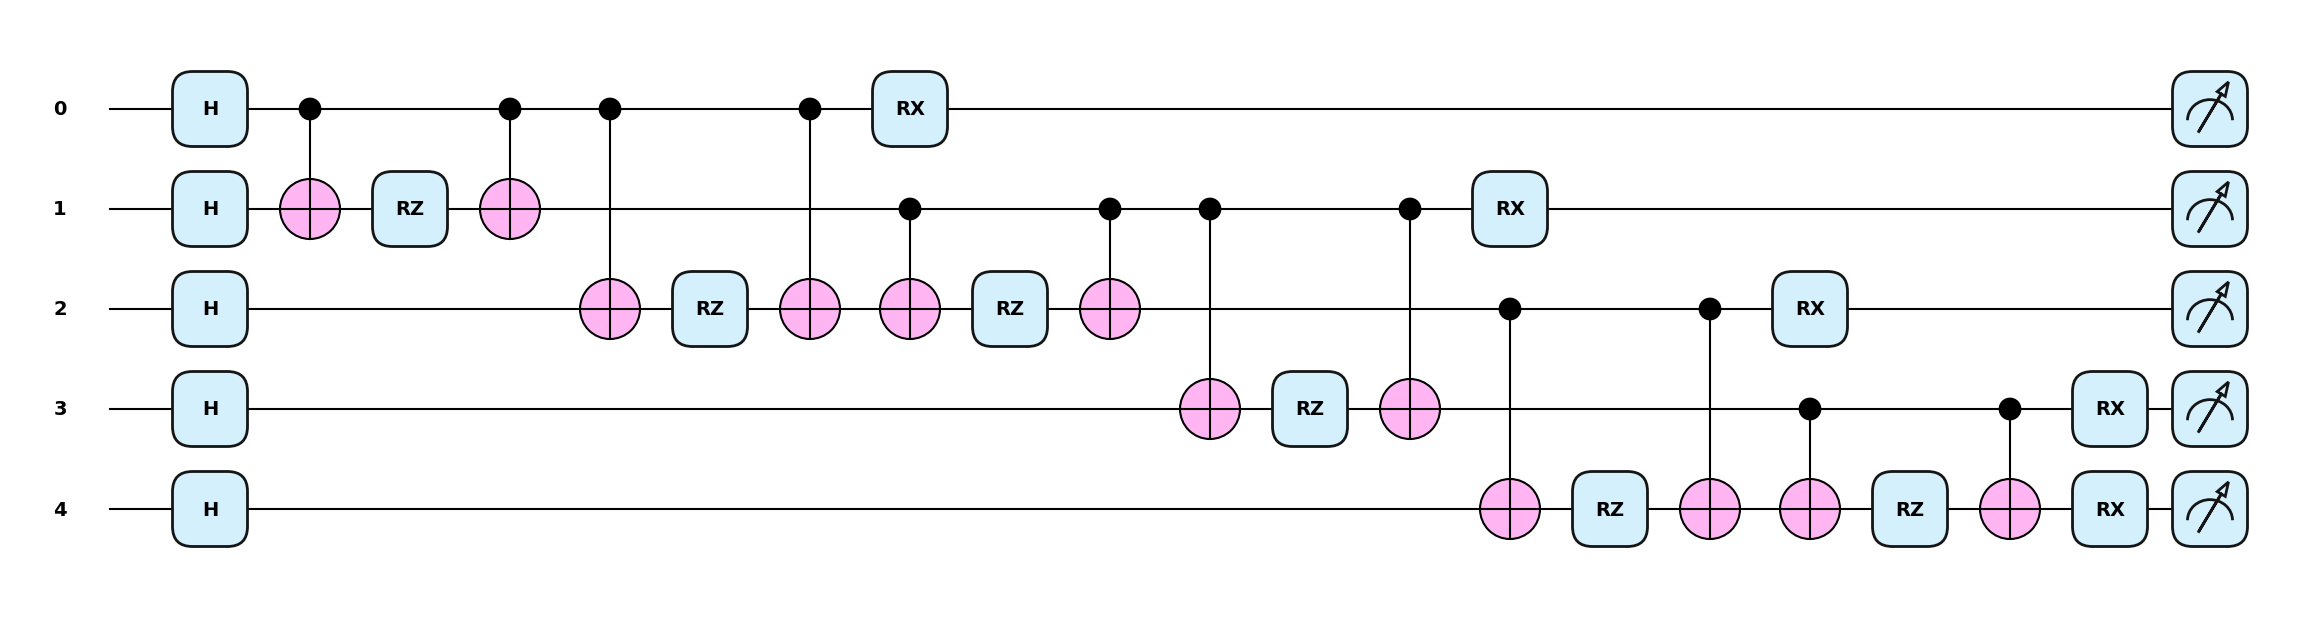

In [43]:
#QAOA Circuit Illustration
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Number of qubits for 5 regions
n_qubits = 5
depth_p = 2

# Initialize a PennyLane device
dev = qml.device("default.qubit", wires=n_qubits)

# Define QAOA ansatz for CVaR QUBO
@qml.qnode(dev)
def qaoa_circuit(gamma, beta):
    # Initial state: |+> for all qubits
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Cost Layer: ZZ interactions (based on edges)
    for (i, j), gamma_val in zip(edges, gamma):
        qml.CNOT(wires=[i, j])
        qml.RZ(2 * gamma_val, wires=j)
        qml.CNOT(wires=[i, j])

    # Mixer Layer: RX(beta) on each qubit
    for i, beta_val in enumerate(beta):
        qml.RX(2 * beta_val, wires=i)

    return qml.state()

# Sample gamma and beta values for visualization
gamma_sample = np.array([0.1]*len(edges))
beta_sample = np.array([0.2]*n_qubits)

# Draw the circuit
fig, ax = qml.drawer.draw_mpl(qaoa_circuit, style="pennylane")(gamma_sample, beta_sample)
fig.savefig("/kaggle/working/circ.png", dpi=600)

In [53]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np

def build_qubo_matrix(risks, corr_matrix, alpha=0.8, beta=0.2):
    """
    Construct the QUBO matrix Q, where:
      Q[i,i] = alpha * risk[i]
      Q[i,j] = beta  * corr_matrix[i,j]   for i < j
    """
    n = len(risks)
    Q = np.zeros((n, n))

    for i in range(n):
        Q[i, i] = alpha * risks[i]

    for i in range(n):
        for j in range(i + 1, n):
            Q[i, j] += beta * corr_matrix[i, j]
            Q[j, i] = Q[i, j]

    return Q

n_qubits = 7
risks = np.array([0.6, 0.6, 0.3, 0.1, 0.5, 0.85, 1])             
corr_matrix = np.array(df_corr)
Q = build_qubo_matrix(risks, corr_matrix, alpha=0.8, beta=0.2)

def cost_hamiltonian_from_qubo(Q):
    """
    Given Q (numpy array n×n), returns a qml.Hamiltonian:
      H_C = sum_i  (Q[i,i] * Z_i)
            + sum_{i<j} (Q[i,j] * Z_i Z_j)
    """
    n = Q.shape[0]
    coeffs = []
    ops = []

    for i in range(n):
        if Q[i, i] != 0.0:
            coeffs.append(Q[i, i])
            ops.append(qml.PauliZ(i))

    for i in range(n):
        for j in range(i + 1, n):
            if Q[i, j] != 0.0:
                coeffs.append(Q[i, j])
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)

def mixer_hamiltonian(n):
    """
    Mixer H_M = sum_{i=0}^{n-1}  X_i
    """
    coeffs = [1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

H_cost = cost_hamiltonian_from_qubo(Q)
H_mixer = mixer_hamiltonian(n_qubits)

p = 3  # QAOA depth

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qaoa_circuit(params):
    """
    QAOA ansatz:
      1) Start in |+>^{⊗n}
      2) For each layer l=0..p-1:
           - Evolve under H_cost for time gamma_l
           - Evolve under H_mixer for time beta_l
      3) Return expectation <H_cost>
    params: a length‐2p vector: [gamma_0, …, gamma_{p-1}, beta_0, …, beta_{p-1}]
    """
    gammas = params[:p]
    betas = params[p : 2 * p]

    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    for layer in range(p):       
        qml.ApproxTimeEvolution(H_cost, gammas[layer], 1)
        qml.ApproxTimeEvolution(H_mixer, betas[layer], 1)
    return qml.expval(H_cost)


init_params = 0.01 * np.random.randn(2 * p)

opt = qml.AdamOptimizer(stepsize=0.01)
steps = 100

params = pnp.array(init_params, requires_grad=True)
for step in range(steps):
    params = opt.step(qaoa_circuit, params)
    if step % 10 == 0:
        cost_val = qaoa_circuit(params)
        print(f"Step {step:>3d}  │  ⟨H_cost⟩ = {cost_val:.5f}")

print("\nFinal optimized parameters:", params)
print("Final cost:", qaoa_circuit(params))

Step   0  │  ⟨H_cost⟩ = -0.00176
Step  10  │  ⟨H_cost⟩ = -0.41811
Step  20  │  ⟨H_cost⟩ = -1.32078
Step  30  │  ⟨H_cost⟩ = -1.93949
Step  40  │  ⟨H_cost⟩ = -2.16242
Step  50  │  ⟨H_cost⟩ = -2.22336
Step  60  │  ⟨H_cost⟩ = -2.23061
Step  70  │  ⟨H_cost⟩ = -2.25521
Step  80  │  ⟨H_cost⟩ = -2.27759
Step  90  │  ⟨H_cost⟩ = -2.29675

Final optimized parameters: [-0.46149236 -0.52813629 -0.69905078  0.46748299  0.24615365  0.34634222]
Final cost: -2.3138686971892812


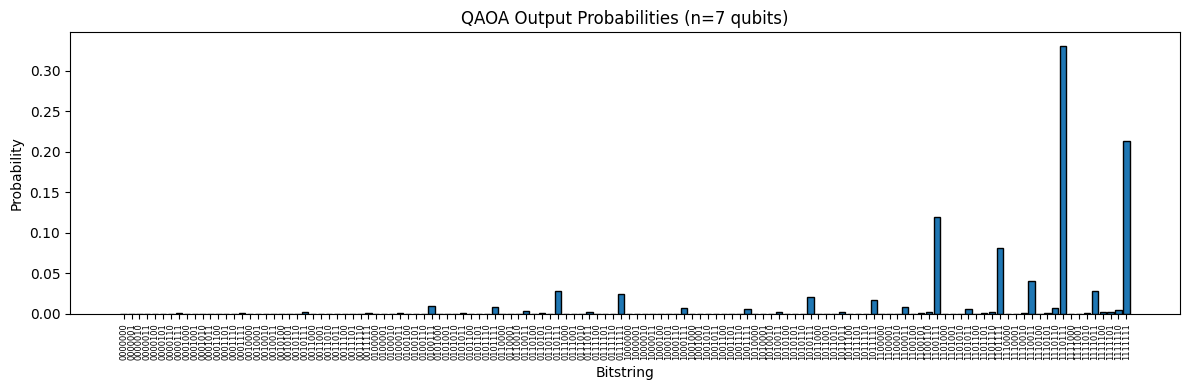

Highest‐probability bitstring: 1110111 (p = 0.3306)
Total QUBO cost for 1110111: 4.2671

Per‐region premiums (for selected regions):
  Region 0: premium = 0.9416
  Region 1: premium = 0.8798
  Region 2: premium = 0.5895
  Region 4: premium = 0.7584
  Region 5: premium = 1.1369
  Region 6: premium = 1.1608


In [54]:
dev_prob = qml.device("default.qubit", wires=n_qubits, shots=None)

@qml.qnode(dev_prob)
def prob_circuit(params):
    gammas = params[:p]
    betas = params[p : 2 * p]

    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    for layer in range(p):
        qml.ApproxTimeEvolution(H_cost, gammas[layer], 1)
        qml.ApproxTimeEvolution(H_mixer, betas[layer], 1)

    return qml.probs(wires=range(n_qubits))

# Compute probabilities at optimized params
probs = prob_circuit(params)  # length = 2^n_qubits
labels = [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]

# Plot the full distribution
plt.figure(figsize=(12, 4))
plt.bar(range(len(labels)), probs, edgecolor="k")
plt.xticks(range(len(labels)), labels, rotation="vertical", fontsize=6)
plt.xlabel("Bitstring")
plt.ylabel("Probability")
plt.title("QAOA Output Probabilities (n=7 qubits)")
plt.tight_layout()
plt.show()

# Identify highest‐probability bitstring
max_index = int(np.argmax(probs))
best_bitstring = labels[max_index]
best_prob = probs[max_index]
print(f"Highest‐probability bitstring: {best_bitstring} (p = {best_prob:.4f})")

# ──────────────────────────────────────────────────────────────────────────────
# 6. Compute total QUBO cost H_C(x) = x^T Q x for that bitstring
# ──────────────────────────────────────────────────────────────────────────────
x_opt = np.array([int(bit) for bit in best_bitstring])
cost_value = x_opt @ Q @ x_opt
print(f"Total QUBO cost for {best_bitstring}: {cost_value:.4f}")

# ──────────────────────────────────────────────────────────────────────────────
# 7. Compute per‐region premium_i = alpha * risk_i + beta * sum_j corr_ij * x_j
# ──────────────────────────────────────────────────────────────────────────────
premium_i = alpha * risks + beta * (corr_matrix @ x_opt)
print("\nPer‐region premiums (for selected regions):")
for i in range(n_qubits):
    if x_opt[i] == 1:
        print(f"  Region {i}: premium = {premium_i[i]:.4f}")